In [1]:
import sys
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/semi_supervised/')
import coreg
reload(coreg)
import trireg
reload(trireg)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ordinal/')
import simple
reload(simple)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ensemble/')
import stacking
reload(stacking)

import pandas as pd
import numpy as np
from sklearn import preprocessing
import xgboost as xgb

import transformers as tforms
reload(tforms)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

import metrics
reload(metrics)
from sklearn.cross_validation import StratifiedKFold, train_test_split

from sklearn.base import clone

from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression

from sklearn.preprocessing import StandardScaler

from collections import Counter
import minirank as mr

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

import cPickle as pickle

def wgmean(x, w):
    return np.exp(np.sum(w*np.log(x), axis=1) / np.sum(w, axis=1))

In [2]:
# Load Data le instead

# train_pd  = pd.read_pickle('saved/train_pd_l_enc.p')
# test_pd  = pd.read_pickle('saved/test_pd_l_enc.p')

train_pd  = pd.read_pickle('saved/train_pd_le_and_oh_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_le_and_oh_enc.p')

labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')
fi = np.load('saved/feature_importances.npy')

y_binned[y_binned==6] = 5

drop_cols = ['T1_V10', 'T1_V13', 'T2_V7', 'T2_V10']
# drop_cols = []

# drop_cols = train_pd.columns[fi < 0.01]


for col in drop_cols:
    train_pd.drop(col, axis=1, inplace=True)
    test_pd.drop(col, axis=1, inplace=True)

In [3]:
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
mapped_train, _y = load_svmlight_file('saved/mapped2000_train.libsvm')

X_2000mean = mapped_train.todense()

In [2]:
# Load Data binary instead
train_pd  = pd.read_pickle('saved/train_pd_binary_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_binary_enc.p')
labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))
y_binned = np.load('saved/y_binned.npy')


In [4]:
X_tsne2 = np.load('saved/X_tsne2_26important.npy')
X_tsne2_train = X_tsne2[:len(train_pd), :]
X_tsne2_test = X_tsne2[-len(test_pd):, :]

print X_tsne2_train.shape
print X_tsne2_test.shape

(50999, 2)
(51000, 2)


In [5]:
y_binned[y_binned==6] = 5

train = np.array(train_pd)
test = np.array(test_pd)

X_train = train.astype(float)
X_test = test.astype(float)
y_train = np.array(labels)

try:
    X_train = np.c_[X_train, X_tsne2_train]
    X_test = np.c_[X_test, X_tsne2_test]
except:
    pass

holdout = False
if holdout:
    X_train, X_hold, \
    y_train, y_hold, \
    y_binned, y_binned_hold \
    = train_test_split(
        X_train, y_train, y_binned, 
        test_size=0.2, random_state=0)


pipe_x = make_pipeline(
    make_union(
        tforms.IdentityTformer(),
#         make_pipeline(AddTformer(1), BoxCoxTformer()),
#         AnscombeTformer(),
    ),
    StandardScaler(),
)
pipe_y = make_pipeline(
#     tforms.IdentityTformer(),
#     tforms.BoxCoxTformer(),
#     tforms.LogTfortforms.mer(),
#     tforms.AnscombeTformer(),
#     tforms.FreemanTukeyTformer(),
#     tforms.ArcsinhTformer(),
    StandardScaler(),
    
)
pipe_x.fit(np.r_[X_train, X_test])


X_train = pipe_x.transform(X_train)
X_test = pipe_x.transform(X_test)
try:
    X_hold = pipe_x.transform(X_hold)
except:
    pass
# y_train = pipe_y.fit_transform(y_train)

# small_n = 5000
# X_train = X_train[:small_n,:]
# y_train = y_train[:small_n]
# y_binned = y_binned[:small_n]

print 'y_train', y_train.shape
print 'X_train', X_train.shape
print 'X_test', X_test.shape
try:
    print 'X_hold', X_hold.shape
except:
    pass
print len(np.unique(y_train))
print len(np.unique(y_binned))
print type(X_train[0][0])

y_train (50999,)
X_train (50999, 125)
X_test (51000, 125)
X_hold 50
5
<type 'numpy.float64'>


# Keras

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, MaxoutDense, Reshape
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adadelta, Adagrad, Adam, RMSprop
from keras.layers.advanced_activations import ParametricSoftplus, PReLU

Using gpu device 0: GeForce GTX 580


In [7]:
X = np.c_[X_2000mean, X_train]
X.shape

(50999, 2125)

In [19]:
# n_feats = X_train.shape[1]
n_feats = X.shape[1]
drop_prob = 0.6

model = Sequential()

# model.add(Dense(111, 512))
# model.add(Dropout(0.2))
# model.add(Activation('relu'))
# # model.add(BatchNormalization(512))
# model.add(Dropout(0.5))
# model.add(Dense(512, 512))
# model.add(Activation('relu'))
# # model.add(BatchNormalization(512))
# model.add(Dropout(0.5))
# model.add(Dense(512, 512))
# model.add(Activation('relu'))
# # model.add(BatchNormalization(512))
# model.add(Dropout(0.5))
# model.add(Dense(512, 1))

hidden_size = 1024
model.add(Dense(n_feats, hidden_size))
model.add(Dropout(0.2))
# model.add(Activation('hard_sigmoid'))
model.add(ParametricSoftplus(hidden_size))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
# model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, hidden_size))
# model.add(Activation('hard_sigmoid'))
model.add(ParametricSoftplus(hidden_size))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
# model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, hidden_size))
# model.add(Activation('hard_sigmoid'))
model.add(ParametricSoftplus(hidden_size))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
# model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, hidden_size))
# model.add(Activation('hard_sigmoid'))
model.add(ParametricSoftplus(hidden_size))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
# model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(drop_prob))
model.add(Dense(hidden_size, 1))

# loss_type = 'mean_squared_error'
# loss_type = 'mae
loss_type = 'msle'


# opt = Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
# opt = Adadelta(lr=0.8, rho=0.90, epsilon=1e-6)
# opt = Adagrad(lr=0.01, epsilon=1e-6)
# opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, kappa=1-1e-8)
opt = RMSprop(lr=0.0005, rho=0.75, epsilon=1e-6)

# loss_type = 'mean_absolute_error'
# model.compile(loss=loss_type, optimizer='rmsprop')

# model.fit(X_train, y_train, nb_epoch=20, batch_size=1024)
# score = model.evaluate(X_test, y_test, batch_size=1024)

model.compile(loss=loss_type, optimizer=opt)
model.save_weights('saved/nn_weights', overwrite=True)

In [20]:
# clf = simple.SimpleOrdinalClassifier(nn)

# clf = KerasClassifier(model=model, optimizer='rmsprop', loss=loss_type)

losses = []
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        pass
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))
# clf = ElasticNet()

scores = []
scores_base = []
n_reps = 1
k = 5
for reps in range(n_reps):
    skf = StratifiedKFold(y_binned, n_folds=k,
                          shuffle=True,
                          random_state=np.random.randint(0,100))
    for ii, (train, valid) in enumerate(skf):
        model.load_weights('saved/nn_weights')
        
        
        history = LossHistory()   # for keras
        print 'Fold %d' % ii,
#         X_train_k = X_train[train]
#         X_valid_k = X_train[valid]
        X_train_k = X[train]
        X_valid_k = X[valid]
        y_train_k = y_train[train]
        y_valid_k = y_train[valid]
#         y_train_k = y_binned[train]
#         y_valid_k = y_binned[valid]
        
        
        
        
        tic = time()
#         clf.fit(X_train_k, y_train_k)
        
#         clf.fit(X_train_k, y_train_k, batch_size=16384, nb_epoch=200)
    
        model.fit(X_train_k, y_train_k, 
                  nb_epoch=500, batch_size=1024*16,
                  validation_data=(X_valid_k, y_valid_k),
                  callbacks=[history],
                  verbose=2)
        
        toc = time() - tic
        print 'Train time: %2.3f s\t' % toc, 

#         valid_preds = clf.predict(X_valid_k)
#         valid_preds = clf.predict_proba(X_valid_k, batch_size=16384).flatten()
        valid_preds = model.predict_proba(X_valid_k, batch_size=16384, verbose=0).flatten()
        
#         score = metrics.gini(y_valid_k, valid_preds)
        score = metrics.normalized_gini(y_valid_k, valid_preds)
        
        print 'Score %1.5f' % score
        scores.append(score)
        
        losses.append(history.losses)
        
        break
        
print "done"
print np.array(scores).mean()

Fold 0Train on 40797 samples, validate on 10202 samples
Epoch 0
1s - loss: 2.2885 - val_loss: 2.2418
Epoch 1
1s - loss: 2.2260 - val_loss: 2.1780
Epoch 2
1s - loss: 2.1665 - val_loss: 2.1189
Epoch 3
1s - loss: 2.1097 - val_loss: 2.0632
Epoch 4
1s - loss: 2.0547 - val_loss: 2.0098
Epoch 5
1s - loss: 2.0011 - val_loss: 1.9570
Epoch 6
1s - loss: 1.9475 - val_loss: 1.9029
Epoch 7
1s - loss: 1.8949 - val_loss: 1.8519
Epoch 8
1s - loss: 1.8421 - val_loss: 1.7994
Epoch 9
1s - loss: 1.7899 - val_loss: 1.7478
Epoch 10
1s - loss: 1.7379 - val_loss: 1.6963
Epoch 11
1s - loss: 1.6863 - val_loss: 1.6452
Epoch 12
1s - loss: 1.6367 - val_loss: 1.5956
Epoch 13
1s - loss: 1.5866 - val_loss: 1.5470
Epoch 14
1s - loss: 1.5375 - val_loss: 1.4990
Epoch 15
1s - loss: 1.4884 - val_loss: 1.4513
Epoch 16
1s - loss: 1.4420 - val_loss: 1.4067
Epoch 17
1s - loss: 1.3957 - val_loss: 1.3609
Epoch 18
1s - loss: 1.3503 - val_loss: 1.3153
Epoch 19
1s - loss: 1.3055 - val_loss: 1.2713
Epoch 20
1s - loss: 1.2625 - val_l

0.352331569833


(0.39, 0.45)

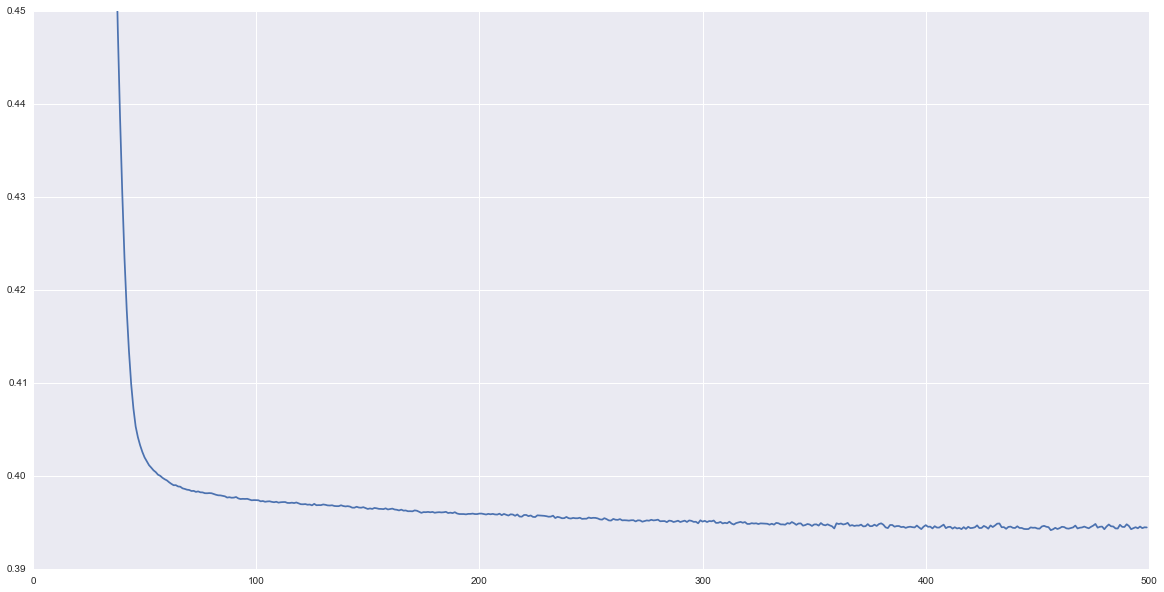

In [24]:
plt.figure(figsize=(20,10))
print np.array(scores).mean()
plt.plot(np.mean(losses, axis=0))
# plt.ylim([0.88, 0.94])
# plt.ylim([0.1, 0.12])
# plt.ylim([14.5, 15.5])
plt.ylim([0.39, 0.45])

[ 2.72351503  3.22279859  2.74496603  4.32277489  3.4688468   4.8109026
  2.28649879  2.8852489   2.24739313  2.19923973]
[ 1  1  5 15  1 14  1  1  4  7]


In [21]:
# 0.345 @ 512 maxout
# 0.365419697668  1000 clusters & original feats

{'loss': 'mean_absolute_error',
 'model': <keras.models.Sequential at 0x7f72ef18dbd0>,
 'optimizer': 'rmsprop'}

# Predict Test Set

In [60]:
model.compile(loss=loss_type, optimizer='rmsprop')
model.fit(X_train, y_train, 
          nb_epoch=10, batch_size=16384,
          callbacks=[history],
          verbose=0)

preds = model.predict_proba(X_test, batch_size=16384, verbose=0).flatten()

In [62]:
print preds.shape
print X_test.shape

(51000,)
(51000, 111)


# Generate submission

In [63]:
preds = pd.DataFrame({"Id": test_ind, "Hazard": preds})
preds = preds.set_index('Id')
preds.to_csv('submissions/keras_benchmark.csv')